# wire tracing algorithm  
this algorithm will be used to find connections between components of a ckt

# image editing for wire tracing

In [89]:
import cv2
import numpy as np
from skimage.morphology import skeletonize

def skeletonize_image(edge_image):
    """
    Computes the skeleton of a binary edge image.

    Args:
        edge_image (ndarray): Binary edge-detected image (output of Canny edge detection).

    Returns:
        ndarray: Skeletonized image with a single-pixel-wide skeleton.
    """
    # Ensure the image is binary (0 or 1 values)
    binary_image = (edge_image > 0).astype(np.uint8)

    # Perform skeletonization
    skeleton = skeletonize(binary_image).astype(np.uint8)

    # Scale back to 0-255 for visualization
    skeleton = skeleton * 255

    return skeleton

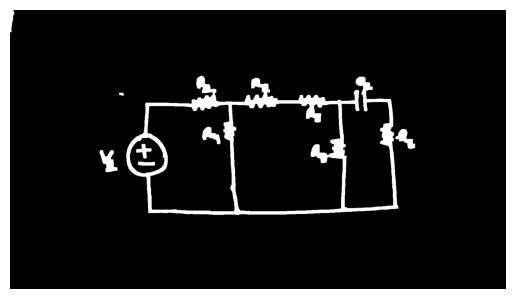

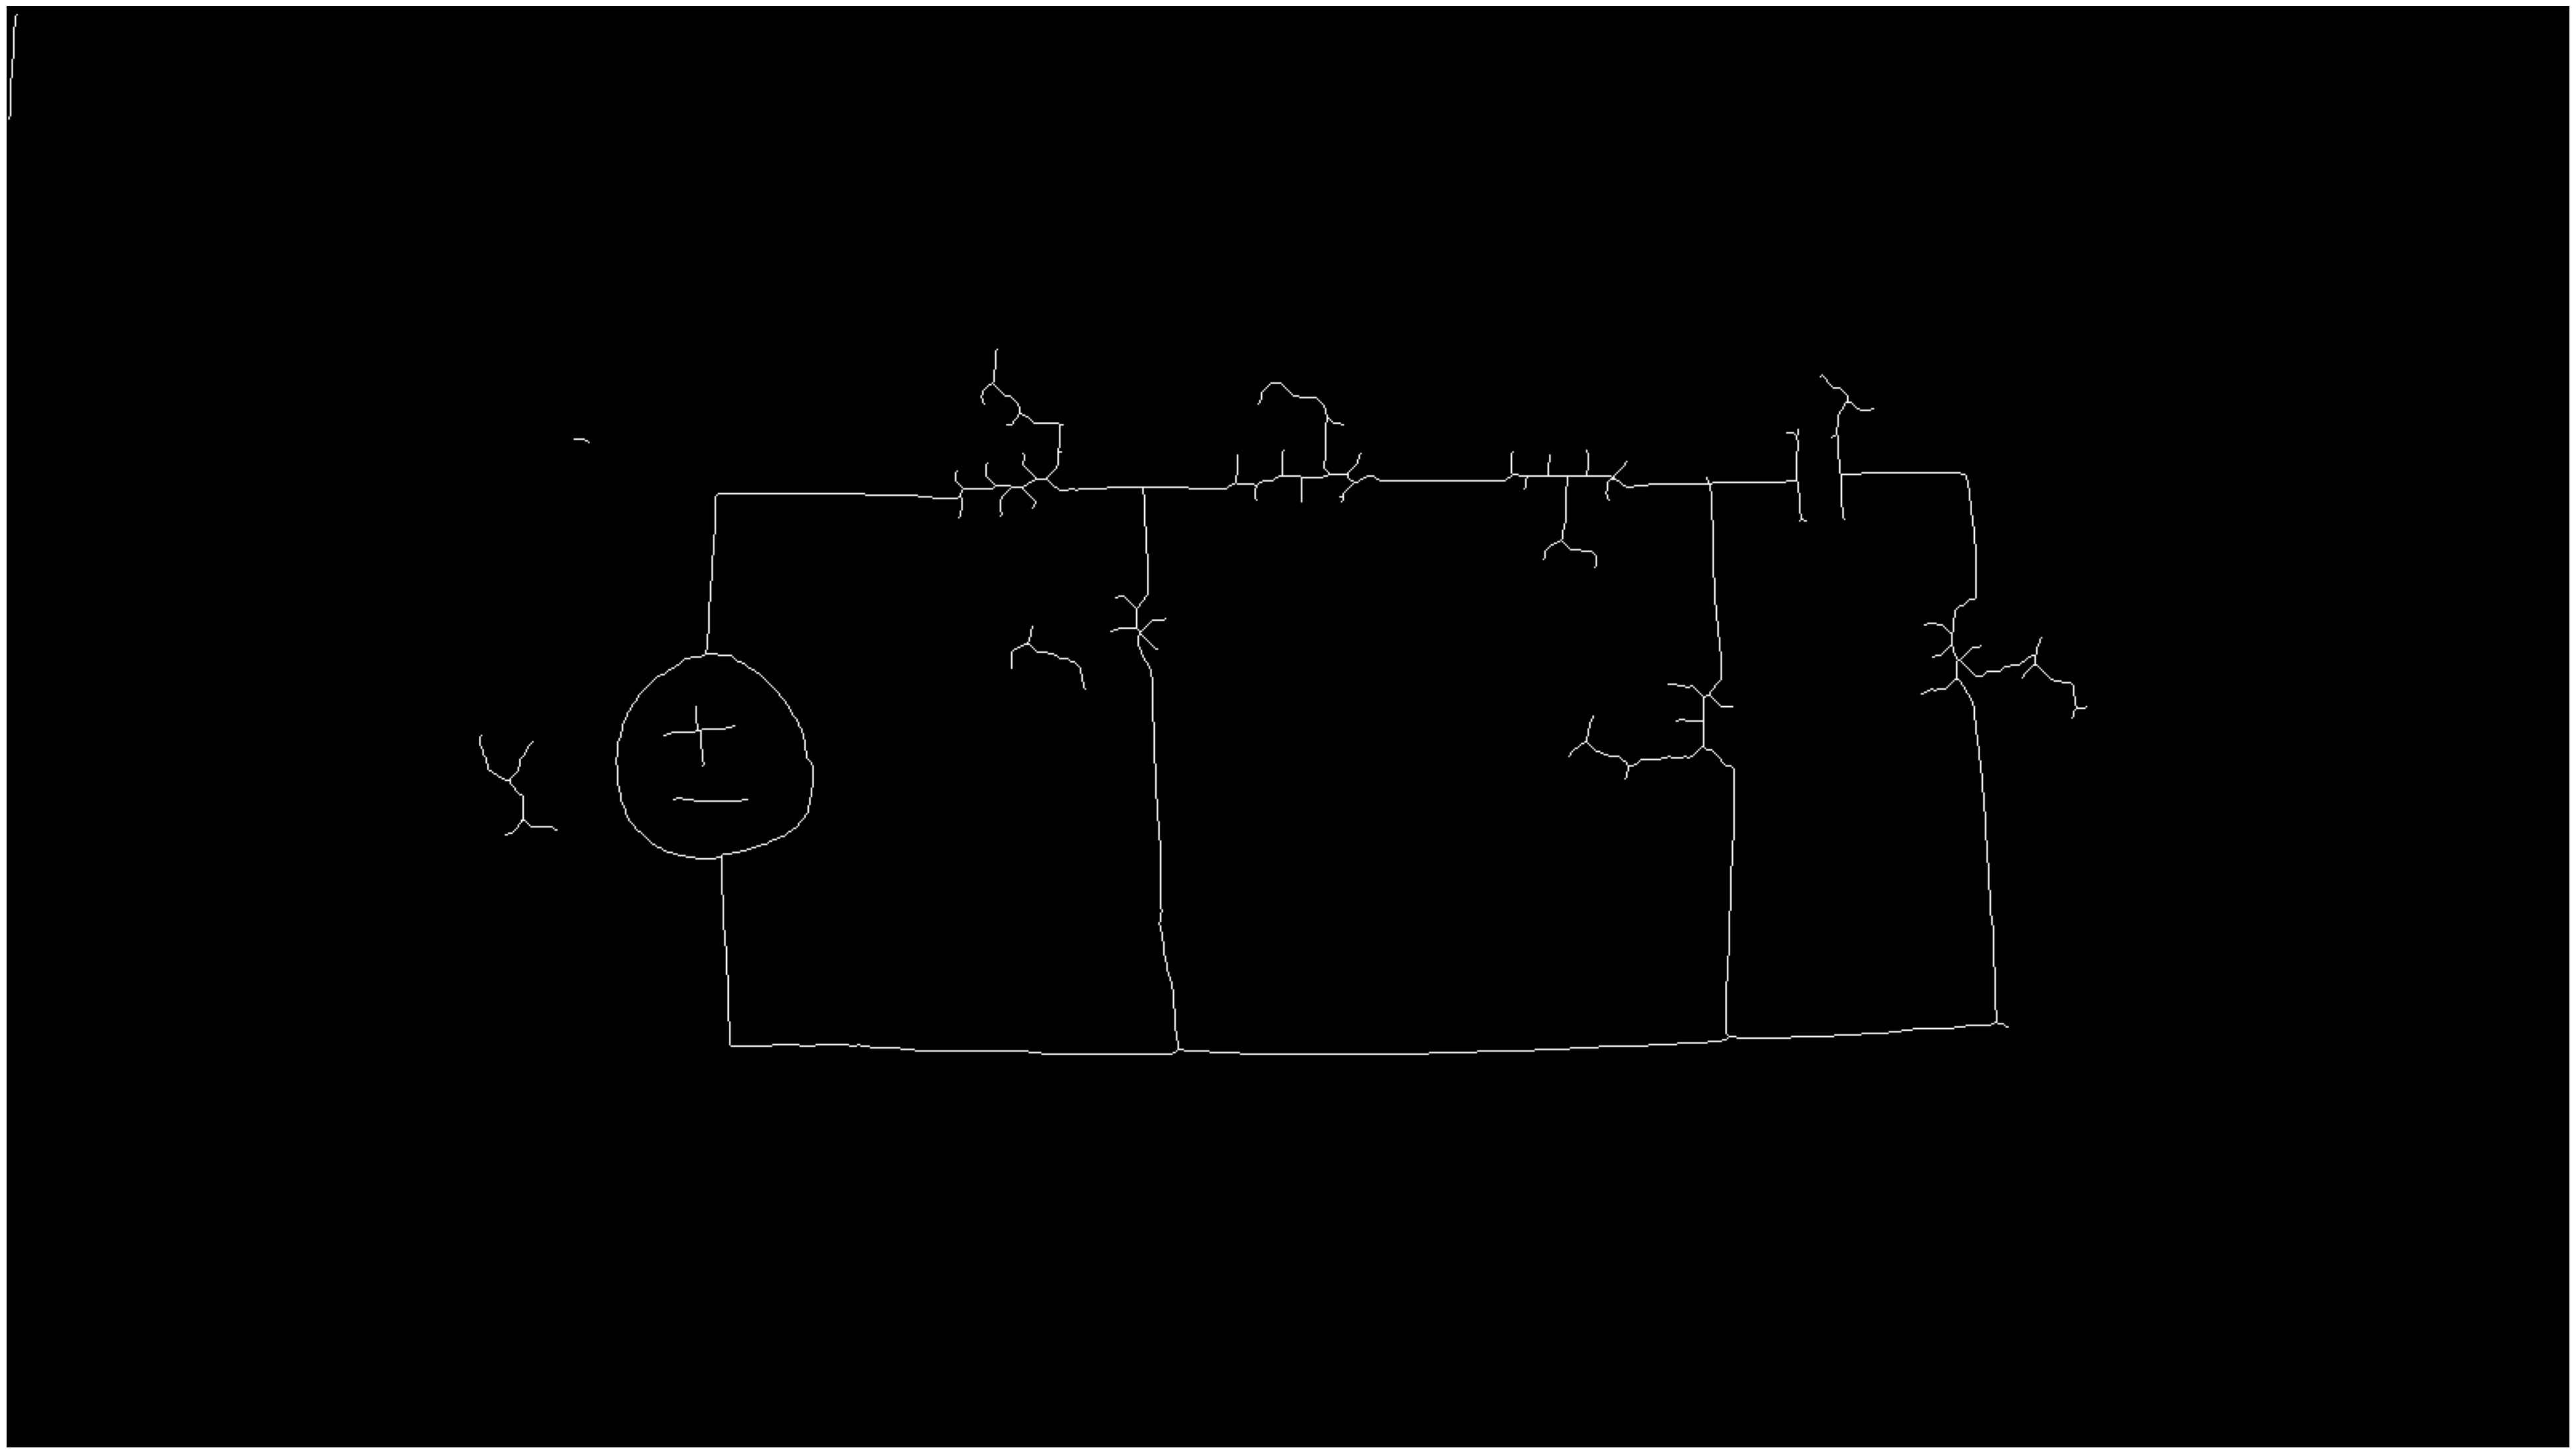

In [90]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt


def segment_high_contrast_portion(image_path):
    # Load the image and convert it to grayscale
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_array = np.array(image)  # Convert to NumPy array

    # Apply Canny edge detection
    edges = cv2.Canny(image_array, 100, 200)  # Adjust thresholds as needed

    # Apply dilation and closing to fill small gaps
    kernel = np.ones((7, 7), np.uint8)  # Adjust the kernel size if needed
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    edges_closed = cv2.morphologyEx(edges_dilated, cv2.MORPH_CLOSE, kernel)

    # Create a new RGBA image to store the final output
    segmented_image = Image.new('L', image.size, (0))

    # Loop through the processed edges and set the pixels to white where edges are detected
    for x in range(image.width):
        for y in range(image.height):
            if edges_closed[y, x] > 0:  # If there is an edge
                segmented_image.putpixel((x, y), (255))  # White with full opacity

    # Convert the PIL image to a NumPy array
    segmented_ckt = np.array(segmented_image)
    segmented_ckt = (segmented_ckt > 0).astype(np.uint8)

    # find skeleton
    skeleton = skeletonize_image(segmented_ckt)
    skeleton = (skeleton > 0).astype(np.uint8)

    return segmented_ckt, skeleton

# Example usage
# path = r"C:\Users\TestUser\Desktop\bring ckt to life - project\example ckts which the final product should work properly on\11_jpg.rf.4ea035771c3f192f8af1456877b81cee.jpg"
# path = r"C:\Users\TestUser\Desktop\bring_ckt_to_life_project\example ckts which the final product should work properly on\signal-2024-11-11-034730_002.jpeg"
# path = r"C:\Users\TestUser\Desktop\bring_ckt_to_life_project\example ckts which the final product should work properly on\maxresdefault.jpg"
# path = r"C:\Users\TestUser\Desktop\bring_ckt_to_life_project\example ckts which the final product should work properly on\4-Figure5-1.png"
# path  = r"C:\Users\TestUser\Desktop\simplest_ckt.jpg"
path = r"C:\Users\TestUser\Desktop\bring_ckt_to_life_project\code\ckt2.jpeg"

from PIL import ImageEnhance
ckt_img = Image.open(path).convert('L')  # Convert to grayscale
enhancer = ImageEnhance.Contrast(ckt_img)
contrast_factor = 2
ckt_img_enhanced = enhancer.enhance(contrast_factor)
# ckt_img_enhanced.show()

segmented_ckt, skeleton_ckt = segment_high_contrast_portion(path)
# print(segmented_array)  # Print the NumPy array representation of the segmented image


# Plot the segmented image
plt.imshow(segmented_ckt, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

plt.figure(figsize=(50, 50))
plt.imshow(skeleton_ckt, cmap='gray')
plt.axis('off')
plt.show()


In [91]:
from get_comp_class_bbox_orient import get_comp_bbox_class_orient
comp_bbox = get_comp_bbox_class_orient(path)

c:\Users\TestUser\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TestUser\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\TestUser\Desktop\bring_ckt_to_life_project\code\classificaiton_model\model.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data wh

In [92]:
non_electrical_comps = [-1, -2]

In [93]:
electrical_component_bbox = comp_bbox.copy()

for index, row in enumerate(electrical_component_bbox):
    if row[0] in non_electrical_comps:
        del electrical_component_bbox[index]

electrical_component_bbox

[[-1, 0.611562, 0.375, 0.031875, 0.0477778],
 [0, 0.707812, 0.325, 0.033125, 0.0788889, 0],
 [2, 0.443125, 0.432778, 0.025, 0.0744444, 0],
 [2, 0.661875, 0.495, 0.0325, 0.0877778, 0],
 [-1, 0.198125, 0.538889, 0.03375, 0.0822222],
 [-1, 0.7975, 0.46, 0.035, 0.0688889],
 [2, 0.610313, 0.324444, 0.056875, 0.0444444, 0],
 [2, 0.3925, 0.331667, 0.0575, 0.0544444, 0],
 [2, 0.760625, 0.443889, 0.02875, 0.0922222, 0],
 [-1, 0.623438, 0.514444, 0.034375, 0.0711111],
 [2, 0.507187, 0.326667, 0.071875, 0.0533333, 0],
 [3, 0.275937, 0.519444, 0.084375, 0.161111, 1]]

# find nodes

In [94]:
# data structures
# components - a 2d python array
# [
#     [component_class, (tuple of nodes connected)],
#     [6, (0,2,4)],
#     [0, (4,6)],
#     [5, (8,10)]
# ]

# nodes - a 2d python array
# [
#     [[end pixels], [node pixels]],
#     [[(2,3), (7,100), (50,60)], [(1,2), (4,5), (10, 20), (50, 60), (100,110)]]
#     ....
# ]

# node_map - a 2d numpy array same as the size of the image
# [20,30] -th element of the array would hold which node does the [20,30]-th pixel of the image belong to 

## necessary functions

In [95]:
import numpy as np
from PIL import Image, ImageDraw

def get_bounding_box_edge_pixels(xywh, img_w, img_h):
    """
    Returns separate arrays of (x, y) coordinates representing the top, left, right, 
    and bottom edge pixels of a bounding box in non-normalized pixel values.

    Args:
    - xywh: list or tuple containing [x, y, w, h] where:
        - x, y: center coordinates of the bounding box as fractions (0 to 1).
        - w, h: full width and full height of the bounding box as fractions (0 to 1).
    - img_w: Width of the image in pixels.
    - img_h: Height of the image in pixels.

    Returns:
    - Four NumPy arrays of (x, y) pixel coordinates for each edge:
      (top_edge, left_edge, right_edge, bottom_edge)
    """
    x, y, w, h = xywh
    
    # Calculate half-width and half-height in pixels
    half_w = int((w * img_w) / 2)
    half_h = int((h * img_h) / 2)
    
    # Calculate the bounding box corners in absolute pixel coordinates
    center_x = int(x * img_w)
    center_y = int(y * img_h)
    
    left = center_x - half_w
    right = center_x + half_w
    top = center_y - half_h
    bottom = center_y + half_h

    # Collect edge pixels without normalization
    top_edge = np.array([(i, top) for i in range(left, right + 1)], dtype=np.int32)
    bottom_edge = np.array([(i, bottom) for i in range(left, right + 1)], dtype=np.int32)
    left_edge = np.array([(left, j) for j in range(top, bottom + 1)], dtype=np.int32)
    right_edge = np.array([(right, j) for j in range(top, bottom + 1)], dtype=np.int32)

    return top_edge, left_edge, right_edge, bottom_edge

# # Example usage
# # Assuming `skeleton_ckt` is a 2D NumPy array representing the original image
# image = skeleton_ckt.copy()  # Assuming `skeleton_ckt` is a predefined numpy array of the image
# img_h, img_w = image.shape

# # Define the bounding box as normalized coordinates (example values)
# xywh = [0.228522, 0.496144, 0.0996564, 0.267352]
# top_edge, left_edge, right_edge, bottom_edge = get_bounding_box_edge_pixels(xywh, img_w, img_h)


def bresenham_line(x1: int, y1: int, x2: int, y2: int):
    """
    Generate the coordinates of pixels in a straight line between two points.
    
    Args:
    - x1, y1: Coordinates of the first pixel.
    - x2, y2: Coordinates of the second pixel.
    
    Returns:
    - A list of (x, y) tuples representing the coordinates of pixels on the line.
    """
    pixels = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        pixels.append((x1, y1))  # Add the current pixel to the list
        if x1 == x2 and y1 == y2:  # If reached the endpoint
            break
        err2 = err * 2
        if err2 > -dy:  # Move in x direction
            err -= dy
            x1 += sx
        if err2 < dx:  # Move in y direction
            err += dx
            y1 += sy
            
    return pixels



In [96]:
def is_same_wire(pix1: tuple, pix2: tuple, ckt_img) -> bool:
    '''
    input: 2 tuples representing 2 pixels
            ckt_img - grayscale PIL image of the ckt
    output: true - the two pixels are actually two sides of the same wire
    ''' 
    print(f'is_same_wire function: {pix1}, {pix2}')
    line_pixels = bresenham_line(pix1[0], pix1[1], pix2[0], pix2[1])
    print(f'line_pixels: {line_pixels} ')
    
    total_color_value = 0 
    for pixel in line_pixels:
        total_color_value = total_color_value + ckt_img.getpixel(pixel)

    avg_color_value = total_color_value/len(line_pixels)
    print(f"avg_color_value between the pixels: {avg_color_value}")
    

    img_arr = np.array(ckt_img)
    img_avg_color = img_arr.mean()
    print('img avg color: ', img_avg_color)
    # thinking that, avg color of the img = the bg color of the img
    # TODO: need to improve here in determining what is bg color
    
    threshold = 50 

    if(abs(img_avg_color - avg_color_value) > threshold):
        # the two pixels belong to the same wire
        return True
    else:
        return False
    
# example use 
is_same_wire((20,30), (30,40), ckt_img_enhanced)

is_same_wire function: (20, 30), (30, 40)
line_pixels: [(20, 30), (21, 31), (22, 32), (23, 33), (24, 34), (25, 35), (26, 36), (27, 37), (28, 38), (29, 39), (30, 40)] 
avg_color_value between the pixels: 62.81818181818182
img avg color:  143.70604375


True

## main algo

In [97]:
non_electrical_comps = [-1, -2] #-1 = text, -2 = wire overlap
non_electrical_comps

[-1, -2]

In [98]:
from itertools import chain

# in pil: pixel => (x, y) 
# in numpy: pixel => (y, x) y= row value, x = column value

# define all data structrues
components = []

node_map = np.full(skeleton_ckt.shape, np.nan)
node_count = 0 # this is basically the assigned node number


for comp_bbox_row in comp_bbox:
# comp_bbox_row =  [13.0, 0.228522, 0.496144, 0.0996564, 0.267352, 1]

    comp_class = comp_bbox_row[0]
    if(comp_class  in non_electrical_comps): continue
    
    comp_orient = comp_bbox_row[5]
    bbox =  comp_bbox_row[1:5]

    list_to_append = [] # a row of the component array
    list_to_append.append(comp_class)
    nodes_to_append = [] # a list containing the nodes of a component

    img_h, img_w = skeleton_ckt.shape
    top_edge, left_edge, right_edge, bottom_edge = get_bounding_box_edge_pixels(bbox, img_w, img_h)

    for edge_index, edge in enumerate([top_edge, right_edge, bottom_edge, left_edge]):
        # edge_index = 0 => top edge, edge_index = 1 => right edge and so on .. 
        for pixel in edge:
            if(edge_index == 0):
                # top_edge
                next_row = pixel[1] - 1
                next_col = pixel[0] 
                next_pixel_val = skeleton_ckt[next_row, next_col]
            elif(edge_index == 1):
                #right edge
                next_row = pixel[1] 
                next_col = pixel[0] + 1
                next_pixel_val = skeleton_ckt[next_row, next_col]
            elif(edge_index == 2):
                # bottom edge
                next_row = pixel[1] + 1 
                next_col = pixel[0]
                next_pixel_val = skeleton_ckt[next_row, next_col]
            else:
                # left edge
                next_row = pixel[1] 
                next_col = pixel[0] - 1
                next_pixel_val = skeleton_ckt[next_row, next_col]



            if(next_pixel_val == 1):
                # add a new node to the component array
                nodes_to_append.append(node_count)
                
                # add the node into the node map
                print(next_row, next_col) # registering this pixel in the node map
                node_map[next_row, next_col] = node_count # node_count is basically the node number assigned to a node

                # increment the nodecount 
                node_count = node_count + 1

    list_to_append.append(nodes_to_append) # adding the nodes list for the component into a row
    list_to_append.append(comp_orient)
    
    components.append(list_to_append) # appending the row for the component to the components matrix

for row in components:
    print(row)



256 1143
291 1159
297 1105
355 712
423 715
405 1070
485 1078
470 1032
299 1022
311 973
296 930
273 657
301 675
307 581
357 1229
415 1241
441 1228
270 823
296 869
301 753
394 437
540 446
[0, [0, 1, 2], 0]
[2, [3, 4], 0]
[2, [5, 6, 7], 0]
[2, [8, 9, 10], 0]
[2, [11, 12, 13], 0]
[2, [14, 15, 16], 0]
[2, [17, 18, 19], 0]
[3, [20, 21], 1]


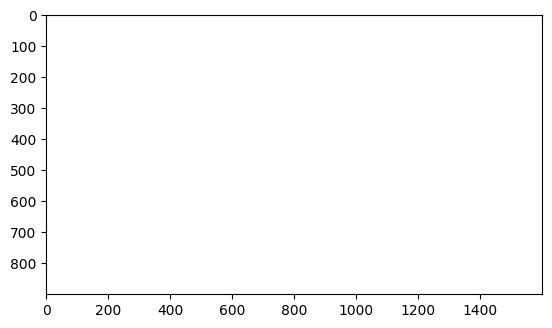

In [99]:
plt.imshow(node_map)
plt.show()

# reduce nodes

In [100]:
# remove all electrical components from the skeleton and find the contours

# remove all elec components from skeleton
skeleton_ckt_stripped = skeleton_ckt.copy() # a 2d numpy array which will have the elec components stripped off 
comp_bbox = comp_bbox # bboxes and comp class in normalized pixel values

non_electrical_comps = non_electrical_comps #classes for components like crossover, junction etc


# Loop through each bounding box
for box in comp_bbox:

    comp_class = box[0]
    
    # Check if the component class is NOT in non_electrical_comps
    if comp_class not in non_electrical_comps:
        _, x, y, w, h, _ = box

        # Convert center-based bbox format (x, y, w, h) to pixel coordinates
        center_x = int(x * skeleton_ckt.shape[1])  # Convert normalized to pixel position
        center_y = int(y * skeleton_ckt.shape[0])
        width = int(w * skeleton_ckt.shape[1])  # Convert normalized width to pixel width
        height = int(h * skeleton_ckt.shape[0])

        # Calculate the top-left and bottom-right coordinates of the box
        x1 = max(0, center_x - width // 2)
        y1 = max(0, center_y - height // 2)
        x2 = min(skeleton_ckt.shape[1], center_x + width // 2)
        y2 = min(skeleton_ckt.shape[0], center_y + height // 2)

        # Mask the region with black pixels (value 0)
        skeleton_ckt_stripped[y1:y2, x1:x2] = 0

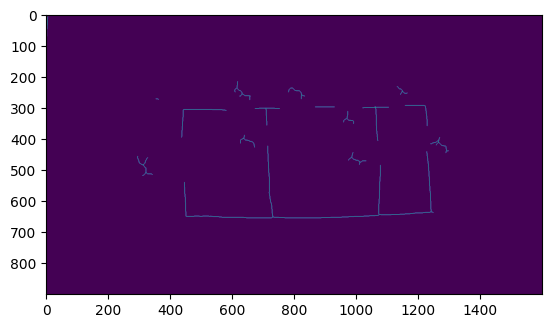

In [101]:
plt.imshow(skeleton_ckt_stripped)

In [102]:
# necessary functions
def remove_duplicates(array):
    for row in array:
        # Convert the second element of each row to a set to remove duplicates, then back to a list
        row[1] = list(set(row[1]))
        # Optionally sort the list to maintain order
        row[1].sort(reverse=True)  # Use reverse=False for ascending order if needed
    return array

# # Example usage
# array = [
#     [0, [2, 2, 2, 1]],
#     [2, [2, 2, 1]],
#     [2, [2, 0, 0]],
#     [3, [1, 0, 0]]
# ]

# # Call the function
# result = remove_duplicates(array)
# print(result)


def reduce_nodes(all_connected_nodes: list):
    #  modify the componenets matrix
    for i, row in enumerate(components):
        tmp = row[1] # the 2nd element of the row holds the list of nodes comp is connected to
        for j, node in enumerate(tmp):
            # going through each node
            for row_index, connected_nodes in enumerate(all_connected_nodes):
                if node in connected_nodes:
                    components[i][1][j] = row_index

    remove_duplicates(components) # removes duplicate nodes in the node list, [1, [2,2,1]] => [1, [2,1]]

    # modify the node_map matrix

    already_updated = []    
    for i in range(node_map.shape[0]):
        for j in range(node_map.shape[1]):
            for row_index, connected_nodes in enumerate(all_connected_nodes):
                if ([i,j] not in already_updated) and (node_map[i, j] in connected_nodes):
                        node_map[i, j] = row_index
                        already_updated.append([i, j])

    


In [103]:
# find all contours on the strippped skeleton ckt
all_contours, _  = cv2.findContours(skeleton_ckt_stripped, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)


In [104]:
import math, pprint

all_connected_nodes = []

for contour in all_contours:
    connected_nodes = []

    for pixel in contour:
        pixel=pixel[0]
        pixel_node = node_map[pixel[1], pixel[0]] #what node does this pixel belong to
        
        if(not math.isnan(pixel_node)):
            # the pixel belongs to a node, so the whole contour belongs to that node
            # print(pixel_node)
            if (pixel_node not in connected_nodes):
                # if the node has not been added into the list, then add
                connected_nodes.append(int(pixel_node.item()))
    
    if(len(connected_nodes) > 1):
        # if a contour does not connect to any node or only connects to one node reject that node
        all_connected_nodes.append(connected_nodes)
    

        # register the pixels of the contour with their new node number
print(f"all_connected_nodes: {pprint.pprint(all_connected_nodes)}")
print("so, all nodes in row 3 of connected nodes will become node 3")

# reducing nodes
reduce_nodes(all_connected_nodes)

[[4, 21, 16, 6], [20, 13], [12, 3, 19], [18, 10], [8, 5, 2], [1, 14]]
all_connected_nodes: None
so, all nodes in row 3 of connected nodes will become node 3


In [105]:
for row in components:
    print(row)

[0, [5, 4, 0], 0]
[2, [2, 0], 0]
[2, [7, 4, 0], 0]
[2, [9, 4, 3], 0]
[2, [11, 2, 1], 0]
[2, [15, 5, 0], 0]
[2, [17, 3, 2], 0]
[3, [1, 0], 1]


In [106]:
for r in node_map:
    for e in r:
        if not math.isnan(e):
            if (e == 0):
                print(e)

0.0
0.0
0.0
0.0
0.0


# make circuit

In [107]:
#####################################################################
# STANDARD DECLARATIONS

import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

import math
from engineering_notation import EngNumber

#####################################################################

In [108]:
name_class_map = {'capacitor_unpolarized': 0, 'inductor': 1, 'resistor': 2, 'vdc': 3}
name_class_map = list(name_class_map.keys())

name_class_map[0]

'capacitor_unpolarized'

In [109]:
# CIRCUIT NETLIST

'''
each component should have the following necessary informations:
comp class
nodes connected to
comp orientation
'''
circuit = Circuit('Captured Circuit from Image')

r_count = 0 # will keep count of how many resistors have been added to the ckt
c_up_count = 0
l_count = 0
vdc_count = 0


for component in components:
    comp_class = component[0]
    comp_name = name_class_map[comp_class]
    
    nodes_connected = component[1]
    nodes_connected = [circuit.gnd if node == 0 else node for node in nodes_connected]
    
    comp_orient = component[2]
    # print(f'component class: {comp_class}, nodes connected to: {nodes_connected}, orientation: {comp_orient}')

    # TODO: using a default value for all components, gotta find a way to extract value
    if(comp_name == 'resistor'):
        # print("adding resistor to ckt")
        r_count = r_count + 1
        
        circuit.R( f"{r_count}", nodes_connected[0], nodes_connected[1], 1 @u_kΩ) 

    elif(comp_name == 'capacitor_unpolarized'):
        # print("adding capactor_unpolarized to ckt")
        c_up_count= c_up_count + 1

        circuit.C(f"{c_up_count}", nodes_connected[0], nodes_connected[1], 1@u_uF)


    elif(comp_name == 'inductor'):
        print("adding inductor to ckt")
        l_count = l_count + 1
        circuit.L(f"{l_count}", nodes_connected[0], nodes_connected[1], 1@u_mH)

    elif(comp_name == 'vdc'):
        print("adding vdc to ckt")
        vdc_count = vdc_count + 1
        
        # TODO: Add polarity handling here

        circuit.V(f"{vdc_count}",  nodes_connected[0], nodes_connected[1], 10@u_V)

    else:
        print(f"component '{comp_name}' not yet implemented")


print("------ netlist of the circuit: ")
print(circuit)

adding vdc to ckt
------ netlist of the circuit: 
.title Captured Circuit from Image
C1 5 4 1uF
R1 2 0 1kOhm
R2 7 4 1kOhm
R3 9 4 1kOhm
R4 11 2 1kOhm
R5 15 5 1kOhm
R6 17 3 1kOhm
V1 1 0 10V



## simulating ckt

In [110]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.operating_point()



NgSpiceCommandError: Command 'run' failed

In [ ]:

for node in analysis.nodes.values():
    print('Node {}: {:4.1f} V'.format(str(node), float(node)))

Node 2:  5.0 V
Node 1: 10.0 V


C:\Users\TestUser\AppData\Local\Temp\ipykernel_14948\3644681373.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Node {}: {:4.1f} V'.format(str(node), float(node)))


In [ ]:

'''
node_voltages[2] => voltage at node 2 of the circuit
'''
node_voltages = [0]


for node in analysis.nodes.values():
    node_voltages.insert(int(str(node)), float(node))

print(node_voltages)

[0, 10.0, 5.0]


C:\Users\TestUser\AppData\Local\Temp\ipykernel_14948\137863637.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  node_voltages.insert(int(str(node)), float(node))


## finding voltage accross components

In [ ]:
def get_comp_voltages(components, node_voltages):
    voltages = []
    for index, component in enumerate(components):     
        comp_class = component[0]
        nodes = component[1]
        # print(nodes)

        t = []
        t.append(comp_class)
        
        volt = abs(node_voltages[nodes[1]] - node_voltages[nodes[0]]) #stores the absolute value of voltage difference across the component
        t.append(volt)

        voltages.append(t)
    
    return voltages

get_comp_voltages(components, node_voltages)

[[3, 10.0], [2, 5.0], [0, 5.0], [2, 5.0]]

In [ ]:
electrical_component_bbox

[[3, 0.313437, 0.599444, 0.079375, 0.141111, 1],
 [2, 0.432187, 0.360556, 0.060625, 0.0611111, 0],
 [0, 0.567813, 0.497778, 0.063125, 0.0511111, 0],
 [2, 0.689062, 0.512778, 0.063125, 0.112222, 0],
 [-1, 0.777188, 0.519444, 0.074375, 0.0855556]]